In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None

In [2]:
if 'snakemake' in locals():
    fam_file = snakemake.input.pop_file
    bim_file = snakemake.input.chrom_file
    kin_file = snakemake.input.kin_file
    sexcheck_file = snakemake.input.sexcheck_file
    hwe_file = snakemake.input.hwe_file
    frq_file = snakemake.input.frq_file
    het_file = snakemake.input.het_file
    imiss_file = snakemake.input.imiss_file
    lmiss_file = snakemake.input.lmiss_file
    stashq_file = snakemake.input.stashq_file
    
    P = f'P <= {snakemake.params.P}'
    f_bound = snakemake.params.f_bound
    imiss_range = snakemake.params.imiss_range
    lmiss_range = snakemake.params.lmiss_range
    
    sample_flags_file_name = str(snakemake.output.sample_flags)
    marker_flags_file_name = str(snakemake.output.marker_flags)
else:
    path = '/proj/regeps/regep00/studies/TopMed/data/dna/whole_genome/TopMed/data/freezes/freeze.10.cdnm/tmp/'
    s_studyid = 'GECOPD'
    
    fam_file = path+"GECOPD_annotated_plink_merged.fam"
    bim_file = path+"GECOPD_annotated_plink_merged.bim"
    kin_file = path+"GECOPD_king_duplicate.con"
    sexcheck_file = path+"GECOPD_annotated_plink_merged.sexcheck"
    hwe_file = path+"GECOPD_annotated_plink_merged.hwe"
    frq_file = path+s_studyid+'_annotated_plink_merged.frq'
    het_file = path+s_studyid+'_annotated_plink_merged.het'
    imiss_file = path+s_studyid+'_annotated_plink_merged.imiss'
    lmiss_file = path+s_studyid+'_annotated_plink_merged.lmiss'
        
    P = "P <= 0.000001"
    f_bound = 0.2
    imiss_range = [10,20]
    lmiss_range = [1,5]
    
    sample_flags_file_name = "flags/GECOPD_samples.csv"
    marker_flags_file_name = "flags/GECOPD_samples.csv"    
    
Error_one = "Error == 1"
Error_two = "Error == 0.5"
Kinship = "Kinship >= 0.354"
SNPSEX = "SNPSEX == 0"


### GECOPD_annotated_plink_merged.fam
#### Show population details

In [4]:
df_fam = pd.read_csv(fam_file, delim_whitespace=True, header=None)
print("# of Rows: " + str(df_fam.shape[0]))

# of Rows: 10697


### GECOPD_annotated_plink_merged.bim
#### Show counts/total for column 0

In [5]:
df_bim = pd.read_csv(bim_file, delim_whitespace=True, header=None)
print("# of rows in column 0: " + str(df_bim[0].count()))

# of rows in column 0: 55362928


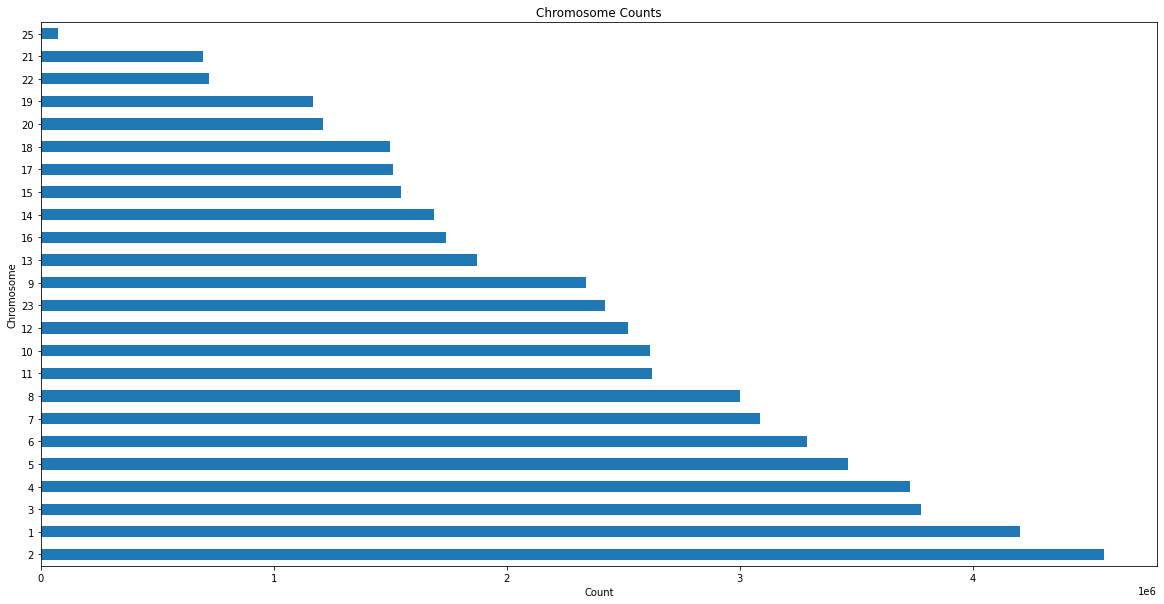

In [6]:
f_plot = plt.figure()
f_plot.set_figwidth(20)
f_plot.set_figheight(10)

df_bim[0].value_counts().plot(kind= "barh");
plt.title("Chromosome Counts");
plt.ylabel("Chromosome");
plt.xlabel("Count");

In [7]:
''' Shows the number of rows and the number of lost rows given certain query contrainsts on a DataFrame

Input:
    - df: DataFrame with data of interest
    - constraints: List of querry strings 
    
Output:
    - result_df: DataFrame showing row count and rows lost
'''
def generate_lost_df(df, constraints):
    diff_data = {}
    
    for curr in constraints:
        df_contrained = df.query(curr)
        diff_data[curr] = [df_contrained.shape[0]]
        
    result_df = pd.DataFrame(data=diff_data, index=["Row Count for Provided Constraint"])
        
    return result_df

## Sample Gender

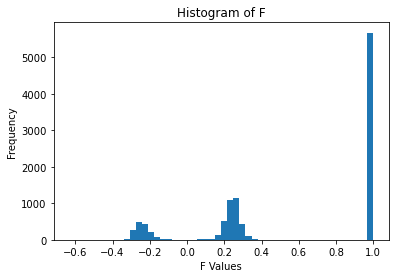

In [8]:
df_sexcheck = pd.read_csv(sexcheck_file, delim_whitespace=True)
plt.hist(df_sexcheck["F"], bins=50);
plt.title("Histogram of F");
plt.ylabel("Frequency");
plt.xlabel("F Values");

#### Table of SNPSEX == 0

In [38]:
df_sexcheck_lost = generate_lost_df(df_sexcheck, [SNPSEX])
df_sexcheck_lost

,SNPSEX == 0
Row Count for Provided Constraint,3115


In [9]:
# flagged samples df_sexcheck
df_sexcheck["Reason"] = SNPSEX
df_sexcheck_flagged = df_sexcheck.query(SNPSEX)[["IID", "Reason"]]

#### Count of each SNPSEX value

In [10]:
df_sex_value_counts = df_sexcheck["SNPSEX"].value_counts()
df_sex_value_counts

#plt.bar(df_sex_value_counts.index, df_sex_value_counts.values);
#plt.title("Value Counts of SNPSEX");
#plt.xlabel("SNPSEX");
#plt.ylabel("Counts");

1    5676
0    3115
2    1906
Name: SNPSEX, dtype: int64

## Hardy-Weinberg Equilibrium

In [11]:
#### P <= configured threshold (default=1x10^-6)
df_hwe = pd.read_csv(hwe_file, delim_whitespace=True)
df_hwe_lost = generate_lost_df(df_hwe, [P])
df_hwe_lost

,P <= 0.000001
Row Count for Provided Constraint,4695395


In [13]:
# flagged markers df_hwe
df_hwe["Reason"] = P
df_hwe_flagged = df_hwe.query(P)[["SNP", "Reason"]]

## Sample Heterozygosity

Samples out of range: 4



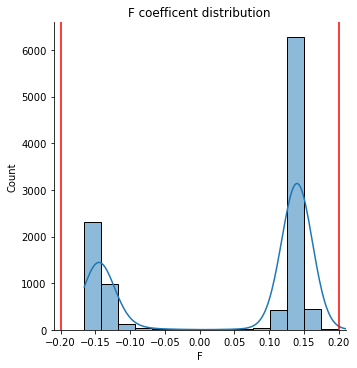

In [14]:
het_tbl = pd.read_csv(het_file, delim_whitespace=True)

def tbl_filtered_fcoe(f):
    
    print('Samples out of range: '+ str(het_tbl['IID'].size - het_tbl.query('F >= -0.2 and F <= 0.2')['IID'].size) + '\n')
    return het_tbl.query('F >= -'+str(f)).query('F <= '+str(f))

tbl_filtered_fcoe(f_bound)

#for the csv of flagged samples
het_sampleflagged = het_tbl.query('F < -0.2 or F > 0.2')

#plots:
plot = sns.displot(het_tbl['F'], kde=True).set(xlim=(-0.21, 0.21))
plt.axvline(0.2).set(color='red')
plt.axvline(-0.2).set(color='red')
plt.title("F coefficent distribution")
plt.show()

## Minor Allele Frequency 

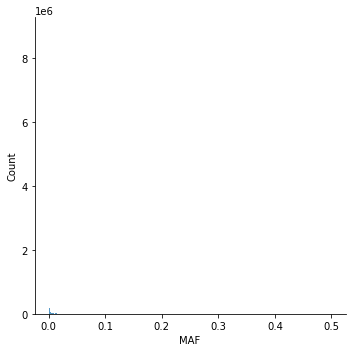

In [15]:
#Which allele is more common and percent of less common allele
frq_tbl = pd.read_csv(frq_file, delim_whitespace=True)
frq_tbl.head()
sns.displot(frq_tbl['MAF'])

In [16]:
## Sample Missingness

               Num of samples
F_MISS % > _%                
total samples           10588
10                         24
11                         21
12                         19
13                         17
14                         16
15                         16
16                         14
17                         10
18                          9
19                          7
20                          7




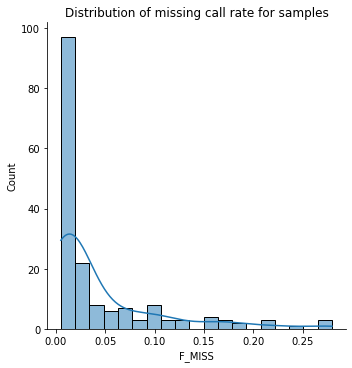

In [21]:
# how many individuals removed from data based on threshold 
imiss_tbl = pd.read_csv(imiss_file, delim_whitespace=True)
    
def filter_missingdata(threshold, tbl):
    total = len(tbl.index)
    filtered = len(tbl.query('F_MISS >'+str(threshold)).index)
    ppl_removed = 'Number of samples: '+str(filtered)
    return filtered

def missingness_range(rnge, tbl):
    bounds = []
    bounds.append(filter_missingdata((0), tbl))
    percents = ['total samples']
    for per in range(rnge[0],rnge[1]+1):
        percents.append(per)
        size = filter_missingdata((per/100), tbl)
        bounds.append(size)

    d = {'Num of samples': bounds}
    df = pd.DataFrame(data=d, index=percents)
    df.index.name = 'F_MISS % > _%'
    return df

print(missingness_range(imiss_range, imiss_tbl))
print('\n')

#plots:
sns.displot(imiss_tbl.query('F_MISS > 0.005')['F_MISS'], kde=True)
plt.title('Distribution of missing call rate for samples')
plt.show()

## Marker Missingness

               Num of samples
F_MISS % > _%                
total samples        38558313
1                      238396
2                           0
3                           0
4                           0
5                           0




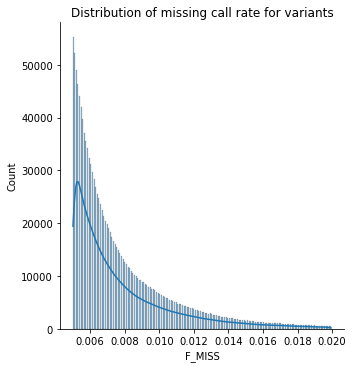

In [22]:
lmiss_tbl = pd.read_csv(lmiss_file, delim_whitespace=True)
print(missingness_range(lmiss_range, lmiss_tbl))
print('\n')
#plots 
sns.displot(lmiss_tbl.query('F_MISS > 0.005')['F_MISS'], kde=True)
plt.title('Distribution of missing call rate for variants')
plt.show()

In [23]:
#samples flagged based on missingness 
imiss_sampleflagged = imiss_tbl.query('F_MISS > 0.1')

#markers flagged based on missingness
lmiss_sampleflagged = lmiss_tbl.query('F_MISS > 0.01')

In [30]:
#sample 
het_sampleid = het_sampleflagged.filter(['IID'])
het_sampleid['Reason'] = 'F < -0.2 or F > 0.2'

imiss_sampleid = imiss_sampleflagged.filter(['IID'])
imiss_sampleid['Reason'] = 'F_MISS > 0.1'

flagged_samples = het_sampleid.append([imiss_sampleid, df_sexcheck_flagged])
flagged_samples.reset_index(drop=True , inplace=True)

flagged_samples.to_csv(sample_flags_file_name)


#markers
lmiss_sampleid = lmiss_sampleflagged.filter(['SNP'])
lmiss_sampleid['Reason'] = 'F_MISS > 0.01'

flagged_markers = lmiss_sampleid.append(df_hwe_flagged)
flagged_markers.reset_index(drop=True , inplace=True)

flagged_markers.to_csv(marker_flags_file_name)

### Kinship data

There are a total of 20873 sample pairs in duplicate.con <br>
There are 57 sample pairs that are correctly labeled as similar <br>
There are 107 samples that do not match <br>
There are 12 subjects referenced in duplicate.con but not found in stashq.txt <br>

In [135]:
df_con = pd.read_csv(kin_file, delim_whitespace=True)
df_con

,FID1,ID1,FID2,ID2,N,N_IBS0,N_IBS1,N_IBS2,Concord,HomConc,HetConc
0,0,NWD119156,0,NWD256937,44236021,2,16404,44219615,0.99963,1.0,0.98993
1,0,NWD115943,0,NWD281964,49419479,0,3895,49415584,0.99992,1.0,0.99790
2,0,NWD107903,0,NWD326325,52865842,0,197,52865645,1.00000,1.0,0.99990
3,0,NWD113690,0,NWD350247,52795710,0,1199,52794511,0.99998,1.0,0.99939
4,0,NWD110199,0,NWD667898,52865098,0,254,52864844,1.00000,1.0,0.99987
...,...,...,...,...,...,...,...,...,...,...,...
171,0,NWD824277,0,NWD894645,44039079,0,20011,44019068,0.99955,1.0,0.99088
172,0,NWD820815,0,NWD965920,52862498,0,706,52861792,0.99999,1.0,0.99965
173,0,NWD901835,0,NWD953197,52858843,0,1261,52857582,0.99998,1.0,0.99936
174,0,NWD930878,0,NWD937800,52864388,0,891,52863497,0.99998,1.0,0.99956


In [122]:
df_txt = pd.read_csv(stashq_file, delim_whitespace=True, names=['ALIASID', '_index_', 'S_SAMPLEID', 'S_SUBJECTID', 'S_STUDYID'])
df_txt

,ALIASID,_index_,S_SAMPLEID,S_SUBJECTID,S_STUDYID
0,NA07357,1/10,ST-00003714,ST-00003714,NaN
1,NA10851,2/10,ST-00020182,ST-00020182,NaN
2,NA11881,3/10,ST-00023037,ST-00023037,NaN
3,NA12003,4/10,ST-00023036,ST-00023036,NaN
4,NA12004,5/10,ST-00014606,ST-00014606,NaN
...,...,...,...,...,...
20869,NWD999849,99/103,S-001116669,ST-00007577,GECOPD
20870,NWD999930,100/103,S-001174118,ST-00078863,GECOPD
20871,NWD999937,101/103,S-000618134,ST-00052808,CRA
20872,NWD999969,102/103,S-000969098,ST-00078944,GECOPD


In [16]:
annotated_concordance_data = df_con.merge(df_txt, left_on='ID1', right_on='ALIASID', how='left')
annotated_concordance_data = annotated_concordance_data.merge(df_txt, left_on='ID2', right_on='ALIASID', how='left', suffixes=('_1', '_2'))
annotated_concordance_data


,FID1,ID1,FID2,ID2,N,N_IBS0,N_IBS1,N_IBS2,Concord,HomConc,...,ALIASID_1,_index__1,S_SAMPLEID_1,S_SUBJECTID_1,S_STUDYID_1,ALIASID_2,_index__2,S_SAMPLEID_2,S_SUBJECTID_2,S_STUDYID_2
0,0,NWD119156,0,NWD256937,44236021,2,16404,44219615,0.99963,1.0,...,NWD119156,47/133,S-001627557,ST-00033679,GECOPD,NWD256937,94/141,S-000954727,ST-00033679,GECOPD
1,0,NWD115943,0,NWD281964,49419479,0,3895,49415584,0.99992,1.0,...,NWD115943,113/136,S-001147221,ST-01002175,GECOPD,NWD281964,35/121,S-001631357,ST-01002175,GECOPD
2,0,NWD107903,0,NWD326325,52865842,0,197,52865645,1.00000,1.0,...,NWD107903,40/117,S-001556889,ST-00007958,GECOPD,NWD326325,84/132,S-001562424,ST-00078627,GECOPD
3,0,NWD113690,0,NWD350247,52795710,0,1199,52794511,0.99998,1.0,...,NWD113690,45/136,S-000559460,ST-00037190,GECOPD,NWD350247,119/131,S-001627663,ST-00037190,GECOPD
4,0,NWD110199,0,NWD667898,52865098,0,254,52864844,1.00000,1.0,...,NWD110199,91/117,S-001110892,ST-00080137,GECOPD,NWD667898,14/110,S-001110973,ST-00073475,GECOPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0,NWD824277,0,NWD894645,44039079,0,20011,44019068,0.99955,1.0,...,NWD824277,79/113,S-001627259,ST-00038086,GECOPD,NWD894645,89/120,S-000541788,ST-00038086,GECOPD
172,0,NWD820815,0,NWD965920,52862498,0,706,52861792,0.99999,1.0,...,NWD820815,5/113,S-001559335,ST-01002705,GECOPD,NaN,NaN,NaN,NaN,NaN
173,0,NWD901835,0,NWD953197,52858843,0,1261,52857582,0.99998,1.0,...,NWD901835,7/117,S-000965466,ST-00078828,GECOPD,NaN,NaN,NaN,NaN,NaN
174,0,NWD930878,0,NWD937800,52864388,0,891,52863497,0.99998,1.0,...,NWD930878,51/142,S-001110946,ST-00073452,GECOPD,NWD937800,99/140,S-001110916,ST-00073553,GECOPD


In [17]:
# shouldn’t match but does
annotated_concordance_data[annotated_concordance_data['S_SUBJECTID_1'] != annotated_concordance_data['S_SUBJECTID_2']]

,FID1,ID1,FID2,ID2,N,N_IBS0,N_IBS1,N_IBS2,Concord,HomConc,...,ALIASID_1,_index__1,S_SAMPLEID_1,S_SUBJECTID_1,S_STUDYID_1,ALIASID_2,_index__2,S_SAMPLEID_2,S_SUBJECTID_2,S_STUDYID_2
2,0,NWD107903,0,NWD326325,52865842,0,197,52865645,1.00000,1.0,...,NWD107903,40/117,S-001556889,ST-00007958,GECOPD,NWD326325,84/132,S-001562424,ST-00078627,GECOPD
4,0,NWD110199,0,NWD667898,52865098,0,254,52864844,1.00000,1.0,...,NWD110199,91/117,S-001110892,ST-00080137,GECOPD,NWD667898,14/110,S-001110973,ST-00073475,GECOPD
5,0,NWD101684,0,NWD724856,52865419,0,420,52864999,0.99999,1.0,...,NWD101684,22/126,S-000537570,ST-00037405,GECOPD,NWD724856,55/115,S-000534418,ST-00031913,GECOPD
6,0,NWD120907,0,NWD844793,52862882,0,936,52861946,0.99998,1.0,...,NWD120907,84/133,S-001110976,ST-00073520,GECOPD,NWD844793,65/120,S-001110908,ST-00073320,GECOPD
7,0,NWD117424,0,NWD957378,52863889,0,2077,52861812,0.99996,1.0,...,NWD117424,12/133,S-001566505,ST-01005151,GECOPD,NWD957378,32/132,S-001627553,ST-01001455,GECOPD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,0,NWD798150,0,NWD817962,52865608,0,270,52865338,0.99999,1.0,...,NWD798150,118/140,S-001151966,ST-01007857,GECOPD,NWD817962,69/119,S-001174809,ST-00079103,GECOPD
172,0,NWD820815,0,NWD965920,52862498,0,706,52861792,0.99999,1.0,...,NWD820815,5/113,S-001559335,ST-01002705,GECOPD,NaN,NaN,NaN,NaN,NaN
173,0,NWD901835,0,NWD953197,52858843,0,1261,52857582,0.99998,1.0,...,NWD901835,7/117,S-000965466,ST-00078828,GECOPD,NaN,NaN,NaN,NaN,NaN
174,0,NWD930878,0,NWD937800,52864388,0,891,52863497,0.99998,1.0,...,NWD930878,51/142,S-001110946,ST-00073452,GECOPD,NWD937800,99/140,S-001110916,ST-00073553,GECOPD


In [61]:
# should match and does
annotated_concordance_data[annotated_concordance_data['S_SUBJECTID_1'] == annotated_concordance_data['S_SUBJECTID_2']]

,FID1,ID1,FID2,ID2,N,N_IBS0,N_IBS1,N_IBS2,Concord,HomConc,...,ALIASID_1,_index__1,S_SAMPLEID_1,S_SUBJECTID_1,S_STUDYID_1,ALIASID_2,_index__2,S_SAMPLEID_2,S_SUBJECTID_2,S_STUDYID_2
0,0,NWD119156,0,NWD256937,44236021,2,16404,44219615,0.99963,1.0,...,NWD119156,47/133,S-001627557,ST-00033679,GECOPD,NWD256937,94/141,S-000954727,ST-00033679,GECOPD
1,0,NWD115943,0,NWD281964,49419479,0,3895,49415584,0.99992,1.0,...,NWD115943,113/136,S-001147221,ST-01002175,GECOPD,NWD281964,35/121,S-001631357,ST-01002175,GECOPD
3,0,NWD113690,0,NWD350247,52795710,0,1199,52794511,0.99998,1.0,...,NWD113690,45/136,S-000559460,ST-00037190,GECOPD,NWD350247,119/131,S-001627663,ST-00037190,GECOPD
11,0,NWD160985,0,NWD432355,52859181,0,1297,52857884,0.99998,1.0,...,NWD160985,11/128,S-001116974,ST-00007731,GECOPD,NWD432355,111/112,S-001556793,ST-00007731,GECOPD
12,0,NWD148690,0,NWD453861,52397445,0,4129,52393316,0.99992,1.0,...,NWD148690,110/132,S-001627264,ST-00075248,GECOPD,NWD453861,131/134,S-001221036,ST-00075248,GECOPD
14,0,NWD156369,0,NWD562651,52861492,0,730,52860762,0.99999,1.0,...,NWD156369,21/118,S-001561333,ST-00076374,GECOPD,NWD562651,116/117,S-001628704,ST-00076374,GECOPD
18,0,NWD185128,0,NWD336319,52864701,0,532,52864169,0.99999,1.0,...,NWD185128,50/125,S-001560425,ST-01006690,GECOPD,NWD336319,54/137,S-001627951,ST-01006690,GECOPD
24,0,NWD172975,0,NWD978302,52861489,1,1238,52860250,0.99998,1.0,...,NWD172975,33/109,S-001590775,ST-00076749,GECOPD,NWD978302,114/119,S-001590776,ST-00076749,GECOPD
29,0,NWD196533,0,NWD689688,48798274,1,14824,48783449,0.99970,1.0,...,NWD196533,71/117,S-001099103,ST-01002570,GECOPD,NWD689688,7/116,S-001627590,ST-01002570,GECOPD
32,0,NWD209404,0,NWD282568,52678902,0,1416,52677486,0.99997,1.0,...,NWD209404,131/140,S-000561553,ST-00037848,GECOPD,NWD282568,48/121,S-000561553,ST-00037848,GECOPD


In [124]:
grouped = df_txt.groupby('S_SUBJECTID')['ALIASID'].apply(lambda x: "%s" % ';'.join(x)).reset_index()
grouped[["ID1", "ID2"]] = grouped["ALIASID"].str.split(";", n=1, expand=True)
grouped.dropna(subset=["ID2"], inplace=True)

In [143]:
# should match but doesn't
final_v2 = grouped.merge(df_con, on=["ID1", "ID2"], how="outer", indicator=True).query("_merge=='left_only'")
final_v2

,S_SUBJECTID,ALIASID,ID1,ID2,FID1,FID2,N,N_IBS0,N_IBS1,N_IBS2,Concord,HomConc,HetConc,_merge
1,ST-00007435,NWD375367;NWD593699,NWD375367,NWD593699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,ST-00007514,NWD680561;NWD849216,NWD680561,NWD849216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,ST-00007639,NWD730283;NWD763691,NWD730283,NWD763691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,ST-00007695,NWD119986;NWD174186,NWD119986,NWD174186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,ST-00007746,NWD550988;NWD565113,NWD550988,NWD565113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,ST-01005316,NWD108023;NWD733322,NWD108023,NWD733322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
616,ST-01006828,NWD193580;NWD697406,NWD193580,NWD697406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
617,ST-01007168,NWD250104;NWD598201,NWD250104,NWD598201,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
618,ST-01007573,NWD493608;NWD929946,NWD493608,NWD929946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
